# Predicting Conversations Gone Awry With Convokit

This interactive tutorial demonstrates how to predict whether a conversation will eventually lead to a personal attack, as seen in the paper [Conversations Gone Awry: Detecting Early Signs of Conversational Failure](http://www.cs.cornell.edu/~cristian/Conversations_gone_awry.html), using the tools provided by ConvoKit. It also serves as an illustration of how to use two transformers implemented by ConvoKit: PromptTypes and politeness strategies.

Note that due to updates in the implementation of ConvoKit modules as well as libraries we've used, the results in the notebook deviate slightly from what was presented in the paper; however, the overall findings match fairly closely.
NOTE: for an updated version of the `PromptTypes` method, using the Expected Conversational Context [Framework](https://tisjune.github.io/research/dissertation) and the `ExpectedContextModel` [functionality](https://convokit.cornell.edu/documentation/expected_context_model.html), see [this notebook](https://github.com/CornellNLP/ConvoKit/blob/master/convokit/expected_context_framework/demos/wiki_awry_demo.ipynb), which uses the same datasets. We keep this demo around to more closely match with the original publication.


In [1]:
import os

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile

from collections import defaultdict
from functools import partial
from multiprocessing import Pool

from convokit import download
from convokit.prompt_types import PromptTypeWrapper
from convokit import PolitenessStrategies
from convokit import Corpus

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load the corpus

The dataset from the Conversations Gone Awry paper is provided through Convokit as "conversations-gone-awry-corpus". We will download this corpus, which includes precomputed SpaCy dependency parses, and use it for our analysis.

In [3]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# AWRY_ROOT_DIR = download('conversations-gone-awry-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# AWRY_ROOT_DIR = '<YOUR DIRECTORY>'

awry_corpus = Corpus(AWRY_ROOT_DIR)
awry_corpus.load_info('utterance',['parsed'])

Dataset already exists at /home/jpchang/.convokit/downloads/conversations-gone-awry-corpus


The original Awry paper and dataset was released at ACL 2018. In the time since initial release, the dataset has been expanded with additional labeled samples, with the later annotation rounds focusing on longer conversations. Since this example notebook is based on the original Awry paper, we will now filter the corpus to keep only the conversations from the original dataset. This can be achieved by checking the "annotation_year" metadata entry; original data will have the value "2018". However, if you may also skip this filtering stage (skip directly to "Step 2: Extract prompt types features") if you wish to run the model on the complete dataset (note that the notebook will take quite a while longer to run).

In [4]:
awry_corpus = awry_corpus.filter_conversations_by(lambda convo: convo.meta['annotation_year'] == '2018')

In [5]:
awry_corpus.print_summary_stats()

Number of Speakers: 2010
Number of Utterances: 6363
Number of Conversations: 1168


## Step 2: Extract prompt types features

In this step, we will extract the first of the two types of pragmatic features seen in the paper: prompt types. We can learn prompt types and compute types for each utterance in the corpus using ConvoKit's PromptTypeWrapper class (which implements an end-to-end pipeline that extracts prompt types; see [this notebook](https://github.com/CornellNLP/ConvoKit/blob/master/examples/prompt-types/prompt-type-demo.ipynb) for examples of particular steps in that pipeline). Note that in keeping with proper machine learning practices, we need a different dataset to use for training the PromptTypeWrapper object. For this, we will use Convokit's Wikipedia talk corpus ("wiki-corpus"), which is composed of Wikipedia talk page conversations different from those found in the Awry corpus.

In [6]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# FULL_ROOT_DIR = download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# FULL_ROOT_DIR = '<YOUR DIRECTORY>'

full_corpus = Corpus(FULL_ROOT_DIR)
full_corpus.load_info('utterance',['parsed'])

We will train a PromptTypeWrapper object on the downloaded corpus. 

(demo continues after long output)

In [8]:
pt_model = PromptTypeWrapper(n_types=6, use_prompt_motifs=False, root_only=False,
                            questions_only=False, enforce_caps=False, min_support=20, min_df=100,
                            svd__n_components=50, max_dist=1., random_state=1000)
pt_model.fit(full_corpus)

10000/391294 utterances processed
20000/391294 utterances processed
30000/391294 utterances processed
40000/391294 utterances processed
50000/391294 utterances processed
60000/391294 utterances processed
70000/391294 utterances processed
80000/391294 utterances processed
90000/391294 utterances processed
100000/391294 utterances processed
110000/391294 utterances processed
120000/391294 utterances processed
130000/391294 utterances processed
140000/391294 utterances processed
150000/391294 utterances processed
160000/391294 utterances processed
170000/391294 utterances processed
180000/391294 utterances processed
190000/391294 utterances processed
200000/391294 utterances processed
210000/391294 utterances processed
220000/391294 utterances processed
230000/391294 utterances processed
240000/391294 utterances processed
250000/391294 utterances processed
260000/391294 utterances processed
270000/391294 utterances processed
280000/391294 utterances processed
290000/391294 utterances proc

Here are the six prompt types that our model has inferred -- i.e., prototypical features of the prompts and responses, as well as prototypical utterances for each type. 

Note that due to updates in SpaCy's dependency parsing, as well as in our implementation of the prompt types methodology, the particular types returned don't fully align with what's in the paper (though we see that they recover similar prompt types, and down the line may result in better performance accuracies). 

demo continues after long output

In [9]:
pt_model.summarize(full_corpus, k=25)

TYPE 0
top prompt:
                  0         1         2         3         4         5  type_id
well_*     0.650458  1.050553  0.702351  1.076953  0.845196  1.096900      0.0
got_*      0.655416  1.092113  0.718272  1.154005  0.838104  1.103844      0.0
too_*      0.663216  1.126098  0.718142  1.138544  0.846150  1.125013      0.0
really_*   0.668041  0.971438  0.806983  1.018529  0.928818  1.132942      0.0
oh>*       0.669572  1.121989  0.788144  1.153735  0.859686  1.171196      0.0
thought_*  0.674321  1.054046  0.766129  1.086536  0.803891  0.997753      0.0
off_*      0.675811  0.962570  0.758636  1.093948  0.933408  1.104960      0.0
oh_*       0.676450  1.121119  0.801333  1.154453  0.860784  1.174679      0.0
:d_*       0.681741  1.073692  0.776019  1.124516  0.879080  1.144497      0.0
yeah>*     0.683447  1.153340  0.806862  1.177334  0.887996  1.238617      0.0
're_*      0.686328  0.929879  0.724062  1.083456  0.897322  1.028071      0.0
lol_*      0.689629  1.147386  0.

We've given them the following names.

In [10]:
TYPE_NAMES = ['Prompt: Casual', 'Prompt: Moderation', 'Prompt: Coordination', 'Prompt: Contention',
             'Prompt: Editing', 'Prompt: Procedures']

Now that the prompt types model has been trained, we can use it to compute prompt types for our present Awry corpus (note that this is a _different_ corpus than what the original model was trained on)

In [11]:
awry_corpus = pt_model.transform(awry_corpus)

6363/6363 utterances processed
6363/6363 utterances processed
6363/6363 utterances processed


Now we want to gather the computed prompt types into a tabular format to use as features for an sklearn estimator. For our purposes, we want the distances from the centers of the KMeans clusters corresponding to each prompt type.

In [12]:
prompt_dist_df = awry_corpus.get_vectors(name='prompt_types__prompt_dists__6', 
                                         as_dataframe=True)
type_ids = np.argmin(prompt_dist_df.values, axis=1)
mask  = np.min(prompt_dist_df.values, axis=1) >= 1.
type_ids[mask] = 6

In [13]:
prompt_dist_df.head()

,type_0_dist,type_1_dist,type_2_dist,type_3_dist,type_4_dist,type_5_dist
146743638.12667.12652,0.904058,0.868544,0.957459,0.847014,0.843779,0.788261
146842219.12874.12874,0.870692,1.001508,0.964857,0.868604,0.762398,0.907913
146860774.13072.13072,0.685944,1.005296,0.811937,0.984351,0.770880,0.998841
143890867.11944.11926,0.951915,0.960689,1.235273,0.812066,1.030613,1.158406
143902946.11991.11991,0.899516,0.758122,0.853924,0.951090,0.910569,0.803753


Later in our analysis, we will also use the particular prompt type that has been assigned to each utterance:

In [14]:
prompt_type_assignments = np.zeros((len(prompt_dist_df), prompt_dist_df.shape[1]+1))
prompt_type_assignments[np.arange(len(type_ids)),type_ids] = 1
prompt_type_assignment_df = pd.DataFrame(columns=np.arange(prompt_dist_df.shape[1]+1), index=prompt_dist_df.index, 
                                        data=prompt_type_assignments)
prompt_type_assignment_df = prompt_type_assignment_df[prompt_type_assignment_df.columns[:-1]]

In [15]:
prompt_type_assignment_df.columns = TYPE_NAMES

In [16]:
prompt_type_assignment_df.head()

,Prompt: Casual,Prompt: Moderation,Prompt: Coordination,Prompt: Contention,Prompt: Editing,Prompt: Procedures
146743638.12667.12652,0.0,0.0,0.0,0.0,0.0,1.0
146842219.12874.12874,0.0,0.0,0.0,0.0,1.0,0.0
146860774.13072.13072,1.0,0.0,0.0,0.0,0.0,0.0
143890867.11944.11926,0.0,0.0,0.0,1.0,0.0,0.0
143902946.11991.11991,0.0,1.0,0.0,0.0,0.0,0.0


## Step 3: Extract politeness strategies features

Now we will extract the second type of pragmatic features described in the paper: politeness strategies. We can do this using convokit's PolitenessStrategies class. This class does not require any training, so we can just apply it directly to the corpus.

In [17]:
ps = PolitenessStrategies(verbose=1000)
awry_corpus = ps.transform(awry_corpus)

1000/6363 utterances processed
2000/6363 utterances processed
3000/6363 utterances processed
4000/6363 utterances processed
5000/6363 utterances processed
6000/6363 utterances processed


Similar to before, we will construct a feature matrix from the computed per-utterance features. In this case, the results can be found in the `politeness_strategies` metadata field.

In [18]:
utterance_ids = awry_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    rows.append(awry_corpus.get_utterance(uid).meta["politeness_strategies"])
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)

In [19]:
politeness_strategies.head(10)

,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,...,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==HASPOSITIVE==,feature_politeness_==HASNEGATIVE==,feature_politeness_==SUBJUNCTIVE==,feature_politeness_==INDICATIVE==
146743638.12652.12652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146743638.12667.12652,0,0,1,0,1,0,0,0,0,0,...,1,1,0,0,1,0,1,1,0,0
146842219.12874.12874,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
146860774.13072.13072,0,0,1,0,1,0,0,1,0,0,...,1,1,0,0,0,1,1,1,0,0
143890867.11926.11926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143890867.11944.11926,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
143902946.11991.11991,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
143945536.12065.12065,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
144052463.12169.12169,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
144065917.12226.12226,0,1,1,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


## Step 4: Create pair data

The analyses performed in the paper, and the prediction task, considers _pairs_ of conversations. The corpus downloaded from convokit already includes metadata about how conversations were paired for the paper, so we don't need to do any of the hard work here. Instead, we'll format the pair information into a table for use in prediction.

In [21]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.conversation_id)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)

# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})
# finally, we will augment the pairs dataframe with the IDs of the first and second comment for both
# the bad and good conversation. This will come in handy for constructing the feature matrix.
first_ids = []
second_ids = []
first_ids_bad = []
second_ids_bad = []
for row in pairs_df.itertuples():
    # "first two" is defined in terms of time of posting
    comments_sorted = comment_df[comment_df.conversation_id==row.conversation_id].sort_values(by="timestamp")
    first_ids.append(comments_sorted.iloc[0].name)
    second_ids.append(comments_sorted.iloc[1].name)
    comments_sorted_bad = comment_df[comment_df.conversation_id==row.bad_conversation_id].sort_values(by="timestamp")
    first_ids_bad.append(comments_sorted_bad.iloc[0].name)
    second_ids_bad.append(comments_sorted_bad.iloc[1].name)
pairs_df = pairs_df.assign(first_id=first_ids, second_id=second_ids, 
                           bad_first_id=first_ids_bad, bad_second_id=second_ids_bad)

# Step 5: Comparing features exhibited

We can compare how often the pragmatic devices we extracted occur in the initial exchanges of conversations that turn awry, vs. conversations that stay on track. We will compute log-odds ratios of each device, comparing the awry and on-track conversations; we will also compute significance values from binomal tests comparing the proportion of awry-turning conversations exhibiting a particular device to the proportion of on-track conversations.

Since we've already got the pragmatic features precomputed, and our dataset of pairs compiled, it remains to compute the effect sizes and statistical significances, and plot these values, producing a plot like Figure 2 from the paper.

Note: due to changes in SpaCy's dependency parsing that took place between the original time of publication and the updated release of this code, the extracted features may differ slightly from the ones used in the paper, so the resulting figure may differ slightly from the one in the paper.

In [22]:
def clean_feature_name(feat):
    new_feat = feat.replace('feature_politeness','').replace('==','').replace('_', ' ')
    split = new_feat.split()
    first, rest = split[0], ' '.join(split[1:]).lower()
    if first[0].isalpha():
        first = first.title()
    if 'Hashedge' in first:
        return 'Hedge (lexicon)'
    if 'Hedges' in first:
        return 'Hedge (dep. tree)'
    if 'greeting' in feat:
        return 'Greetings'
    cleaner_str = first + ' ' + rest
#     cleaner_str = cleaner_str.replace('2nd', '2$\mathregular{^{nd}}$').replace('1st', '1$\mathregular{^{st}}$')
    return cleaner_str

In [23]:
politeness_strategies_display = politeness_strategies[[col for col in politeness_strategies.columns 
                  if col not in ['feature_politeness_==HASNEGATIVE==', 'feature_politeness_==HASPOSITIVE==']]].copy()
politeness_strategies_display.columns = [clean_feature_name(col) for col in politeness_strategies_display.columns]

In [24]:
all_features = politeness_strategies_display.join(prompt_type_assignment_df)

In [25]:
tox_first_comment_features =pairs_df[['bad_first_id']].join(all_features, how='left', on='bad_first_id')[all_features.columns]
ntox_first_comment_features =pairs_df[['first_id']].join(all_features, how='left', on='first_id')[all_features.columns]

tox_second_comment_features =pairs_df[['bad_second_id']].join(all_features, how='left', on='bad_second_id')[all_features.columns]
ntox_second_comment_features =pairs_df[['second_id']].join(all_features, how='left', on='second_id')[all_features.columns]

In [26]:
def get_p_stars(x):
    if x < .001: return '***'
    elif x < .01: return '**'
    elif x < .05: return '*'
    else: return ''
def compare_tox(df_ntox, df_tox,  min_n=0):
    cols = df_ntox.columns
    num_feats_in_tox = df_tox[cols].sum().astype(int).rename('num_feat_tox')
    num_nfeats_in_tox = (1 - df_tox[cols]).sum().astype(int).rename('num_nfeat_tox')
    num_feats_in_ntox = df_ntox[cols].sum().astype(int).rename('num_feat_ntox')
    num_nfeats_in_ntox = (1 - df_ntox[cols]).sum().astype(int).rename('num_nfeat_ntox')
    prop_tox = df_tox[cols].mean().rename('prop_tox')
    ref_prop_ntox = df_ntox[cols].mean().rename('prop_ntox')
    n_tox = len(df_tox)
    df = pd.concat([
        num_feats_in_tox, 
        num_nfeats_in_tox,
        num_feats_in_ntox,
        num_nfeats_in_ntox,
        prop_tox,
        ref_prop_ntox,
    ], axis=1)
    df['num_total'] = df.num_feat_tox + df.num_feat_ntox
    df['log_odds'] = np.log(df.num_feat_tox) - np.log(df.num_nfeat_tox) \
        + np.log(df.num_nfeat_ntox) - np.log(df.num_feat_ntox)
    df['abs_log_odds'] = np.abs(df.log_odds)
    df['binom_p'] = df.apply(lambda x: stats.binomtest(int(x.num_feat_tox), n_tox, x.prop_ntox).pvalue, axis=1)
    df = df[df.num_total >= min_n]
    df['p'] = df['binom_p'].apply(lambda x: '%.3f' % x)
    df['pstars'] = df['binom_p'].apply(get_p_stars)
    return df.sort_values('log_odds', ascending=False)

In [27]:
first_comparisons = compare_tox(ntox_first_comment_features, tox_first_comment_features)
second_comparisons = compare_tox(ntox_second_comment_features, tox_second_comment_features)

In [28]:
# we are now ready to plot these comparisons. the following (rather intimidating) helper function 
# produces a nicely-formatted plot:
def draw_figure(ax, first_cmp, second_cmp, title='', prompt_types=6, min_log_odds=.2, min_freq=50,xlim=.85):

    # selecting and sorting the features to plot, given minimum effect sizes and statistical significance
    frequent_feats = first_cmp[first_cmp.num_total >= min_freq].index.union(second_cmp[second_cmp.num_total >= min_freq].index)
    lrg_effect_feats = first_cmp[(first_cmp.abs_log_odds >= .2)
                                & (first_cmp.binom_p < .05)].index.union(second_cmp[(second_cmp.abs_log_odds >= .2)
                                                                                  & (second_cmp.binom_p < .05)].index)
    feats_to_include = frequent_feats.intersection(lrg_effect_feats)
    feat_order = sorted(feats_to_include, key=lambda x: first_cmp.loc[x].log_odds, reverse=True)

    # parameters determining the look of the figure
    colors = ['darkorchid', 'seagreen']
    shapes = ['d', 's']    
    eps = .02
    star_eps = .035
    xlim = xlim
    min_log = .2
    gap_prop = 2
    label_size = 14
    title_size=18
    radius = 144
    features = feat_order
    ax.invert_yaxis()
    ax.plot([0,0], [0, len(features)/gap_prop], color='black')
    
    # for each figure we plot the point according to effect size in the first and second comment, 
    # and add axis labels denoting statistical significance
    yticks = []
    yticklabels = []
    for f_idx, feat in enumerate(features):
        curr_y = (f_idx + .5)/gap_prop
        yticks.append(curr_y)
        try:
            
            first_p = first_cmp.loc[feat].binom_p
            second_p = second_cmp.loc[feat].binom_p            
            if first_cmp.loc[feat].abs_log_odds < min_log:
                first_face = "white"
            elif first_p >= 0.05:
                first_face = 'white'
            else:
                first_face = colors[0]
            if second_cmp.loc[feat].abs_log_odds < min_log:
                second_face = "white"
            elif second_p >= 0.05:
                second_face = 'white'
            else:
                second_face = colors[1]
            ax.plot([-1 * xlim, xlim], [curr_y, curr_y], '--', color='grey', zorder=0, linewidth=.5)
            
            ax.scatter([first_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[0], marker=shapes[0],
                        zorder=20, facecolors=first_face)
            ax.scatter([second_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[1], marker=shapes[1], 
                       zorder=10, facecolors=second_face)
            
            first_pstr_len = len(get_p_stars(first_p))
            second_pstr_len = len(get_p_stars(second_p))
            p_str = np.array([' '] * 8)
            if first_pstr_len > 0:
                p_str[:first_pstr_len] = '*'
            if second_pstr_len > 0:
                p_str[-second_pstr_len:] = '⁺'
            
            feat_str = feat + '\n' + ''.join(p_str)
            yticklabels.append(feat_str)
        except Exception as e:
            yticklabels.append('')
    
    # add the axis labels
    ax.set_xlabel('log-odds ratio', fontsize=14, family='serif')
    ax.set_xticks([-xlim-.05, -.5, 0, .5, xlim])
    ax.set_xticklabels(['on-track', -.5, 0, .5, 'awry'], fontsize=14, family='serif')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=16, family='serif')
    ax.tick_params(axis='both',  which='both', bottom='off',  top='off',left='off')
    if title != '':
        ax.text(0, (len(features) + 2.25)/ gap_prop, title, fontsize=title_size, family='serif',horizontalalignment='center',)
    return feat_order

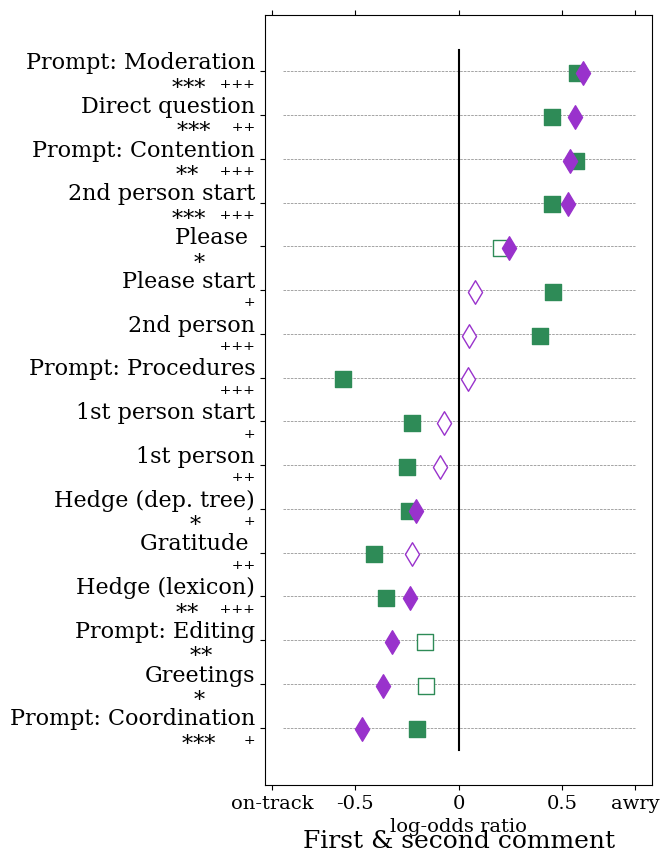

In [29]:
f, ax = plt.subplots(1,1, figsize=(5,10))
_ = draw_figure(ax, first_comparisons, second_comparisons, 'First & second comment')

## Step 6: Construct feature matrix

To run the prediction task, we can construct a table of pragmatic features for each pair, to use in prediction. This table will consist of the prompt types and politeness strategies for the first and second comment of each conversation.

In [30]:
def features_for_convo(convo_id, first_comment_id, second_comment_id):

    # get prompt type features
    try:
        first_prompts = prompt_dist_df.loc[first_comment_id]
    except:
        first_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=prompt_dist_df.columns)
    try:
        second_prompts = prompt_dist_df.loc[second_comment_id].rename({c: c + "_second" for c in prompt_dist_df.columns})
    except:
        second_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=[c + "_second" for c in prompt_dist_df.columns])
    prompts = pd.concat([first_prompts, second_prompts])
    # get politeness strategies features
    first_politeness = politeness_strategies.loc[first_comment_id]
    second_politeness = politeness_strategies.loc[second_comment_id].rename({c: c + "_second" for c in politeness_strategies.columns})
    politeness = pd.concat([first_politeness, second_politeness])
    return pd.concat([politeness, prompts])

In [31]:
convo_ids = np.concatenate((pairs_df.conversation_id.values, pairs_df.bad_conversation_id.values))
feats = [features_for_convo(row.conversation_id, row.first_id, row.second_id) for row in pairs_df.itertuples()] + \
        [features_for_convo(row.bad_conversation_id, row.bad_first_id, row.bad_second_id) for row in pairs_df.itertuples()]
feature_table = pd.DataFrame(data=np.vstack([f.values for f in feats]), columns=feats[0].index, index=convo_ids)

In [32]:
# in the paper, we dropped the sentiment lexicon based features (HASPOSITIVE and HASNEGATIVE), opting
# to instead use them as a baseline. We do this here as well to be consistent with the paper.
feature_table = feature_table.drop(columns=["feature_politeness_==HASPOSITIVE==",
                                            "feature_politeness_==HASNEGATIVE==",
                                            "feature_politeness_==HASPOSITIVE==_second",
                                            "feature_politeness_==HASNEGATIVE==_second"])

In [33]:
feature_table.head(5)


,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,...,type_2_dist,type_3_dist,type_4_dist,type_5_dist,type_0_dist_second,type_1_dist_second,type_2_dist_second,type_3_dist_second,type_4_dist_second,type_5_dist_second
567687735.949.949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.850312,0.956796,0.915524,0.837982,0.942460,0.767894,0.930565,0.862600,0.906304,0.804883
112610040.70740.70740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,0.890528,0.936728,0.804962,0.982559,0.725396,0.786844
196614506.567.567,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.659193,1.016176,0.771315,0.787086,0.814219,0.773791,0.926349,0.887222,0.906669,0.942368
20086777.0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.852175,0.983225,0.771682,0.957737,0.748956,0.975885,0.760232,1.010337,0.754015,0.899552
183625284.22030.22030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.980389,0.904754,0.921520,0.873970,0.799298,0.857325,0.702609,1.039301,0.924078,0.878469


## Step 7: Prediction Utils

We're almost ready to do the prediction! First we need to define a few helper functions...

In [34]:
def mode(seq):
    vals, counts = np.unique(seq, return_counts=True)
    return vals[np.argmax(counts)]

def run_pred_single(inputs, X, y):
    f_idx, (train_idx, test_idx) = inputs
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    base_clf = Pipeline([("scaler", StandardScaler()), ("featselect", SelectPercentile(score_func=f_classif, percentile=10)), ("logreg", LogisticRegression(solver='liblinear'))])
    clf = GridSearchCV(base_clf, {"logreg__C": [10**i for i in range(-4,4)], "featselect__percentile": list(range(10, 110, 10))}, cv=3)

    clf.fit(X_train, y_train)
    
    y_scores = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    
    feature_weights = clf.best_estimator_.named_steps["logreg"].coef_.flatten()
    feature_mask = clf.best_estimator_.named_steps["featselect"].get_support()
    
    hyperparams = clf.best_params_
    
    return (y_pred, y_scores, feature_weights, hyperparams, feature_mask)

def run_pred(X, y, fnames, groups):
    feature_weights = {}
    scores = np.asarray([np.nan for i in range(len(y))])
    y_pred = np.zeros(len(y))
    hyperparameters = defaultdict(list)
    splits = list(enumerate(LeaveOneGroupOut().split(X, y, groups)))
    accs = []
        
    with Pool(os.cpu_count()) as p:
        prediction_results = p.map(partial(run_pred_single, X=X, y=y), splits)
        
    fselect_pvals_all = []
    for i in range(len(splits)):
        f_idx, (train_idx, test_idx) = splits[i]
        y_pred_i, y_scores_i, weights_i, hyperparams_i, mask_i = prediction_results[i]
        y_pred[test_idx] = y_pred_i
        scores[test_idx] = y_scores_i
        feature_weights[f_idx] = np.asarray([np.nan for _ in range(len(fnames))])
        feature_weights[f_idx][mask_i] = weights_i
        for param in hyperparams_i:
            hyperparameters[param].append(hyperparams_i[param])   
    
    acc = np.mean(y_pred == y)
    pvalue = stats.binomtest(sum(y_pred == y), n=len(y), alternative="greater").pvalue
                
    coef_df = pd.DataFrame(feature_weights, index=fnames)
    coef_df['mean_coef'] = coef_df.apply(np.nanmean, axis=1)
    coef_df['std_coef'] = coef_df.apply(np.nanstd, axis=1)
    return acc, coef_df[['mean_coef', 'std_coef']], scores, pd.DataFrame(hyperparameters), pvalue

def get_labeled_pairs(pairs_df):
    paired_labels = []
    c0s = []
    c1s = []
    page_ids = []
    for i, row in enumerate(pairs_df.itertuples()):
        if i % 2 == 0:
            c0s.append(row.conversation_id)
            c1s.append(row.bad_conversation_id)
        else:
            c0s.append(row.bad_conversation_id)
            c1s.append(row.conversation_id)
        paired_labels.append(i%2)
        page_ids.append(row.page_id)
    return pd.DataFrame({"c0": c0s, "c1": c1s,"first_convo_toxic": paired_labels, "page_id": page_ids})

def get_feature_subset(labeled_pairs_df, feature_list):
    prompt_type_names = ["type_%d_dist" % i for i in range(6)] + ["type_%d_dist_second" % i for i in range(6)]
    politeness_names = [f for f in feature_table.columns if f not in prompt_type_names]
    
    features_to_use = []
    if "prompt_types" in feature_list:
        features_to_use += prompt_type_names
    if "politeness_strategies" in feature_list:
        features_to_use += politeness_names
        
    feature_subset = feature_table[features_to_use]
    
    c0_feats = feature_subset.loc[labeled_pairs_df.c0].values
    c1_feats = feature_subset.loc[labeled_pairs_df.c1].values
    
    return c0_feats, c1_feats, features_to_use

def run_pipeline(feature_set):
    print("Running prediction task for feature set", "+".join(feature_set))
    print("Generating labels...")
    labeled_pairs_df = get_labeled_pairs(pairs_df)
    print("Computing paired features...")
    X_c0, X_c1, feature_names = get_feature_subset(labeled_pairs_df, feature_set)
    X = X_c1 - X_c0
    print("Using", X.shape[1], "features")
    y = labeled_pairs_df.first_convo_toxic.values
    print("Running leave-one-page-out prediction...")
    accuracy, coefs, scores, hyperparams, pvalue = run_pred(X, y, feature_names, labeled_pairs_df.page_id)
    print("Accuracy:", accuracy)
    print("p-value: %.4e" % pvalue)
    print("C (mode):", mode(hyperparams.logreg__C))
    print("Percent of features (mode):", mode(hyperparams.featselect__percentile))
    print("Coefficents:")
    print(coefs.sort_values(by="mean_coef"))
    return accuracy

## Step 8: Prediction

Finally, we run the prediction task on each possible combination of pragmatic features: prompt types, politeness strategies, and both combined. We generate a table like Table 3 from the paper.

In [35]:
feature_combos = [["politeness_strategies"], ["prompt_types"], ["politeness_strategies", "prompt_types"]]
combo_names = []
accs = []
for combo in feature_combos:
    combo_names.append("+".join(combo).replace("_", " "))
    accuracy = run_pipeline(combo)
    accs.append(accuracy)
results_df = pd.DataFrame({"Accuracy": accs}, index=combo_names)
results_df.index.name = "Feature set"

Running prediction task for feature set politeness_strategies
Generating labels...
Computing paired features...
Using 38 features
Running leave-one-page-out prediction...
Accuracy: 0.5856164383561644
p-value: 2.0131e-05
C (mode): 1.0
Percent of features (mode): 50
Coefficents:
                                                   mean_coef  std_coef
feature_politeness_==2nd_person==_second           -0.271286  0.100911
feature_politeness_==2nd_person_start==            -0.212867  0.078583
feature_politeness_==Direct_question==             -0.173351  0.062528
feature_politeness_==2nd_person_start==_second     -0.169574  0.062180
feature_politeness_==Direct_question==_second      -0.126067  0.045845
feature_politeness_==Please_start==_second         -0.089352  0.032522
feature_politeness_==Please==                      -0.075373  0.029474
feature_politeness_==Factuality==                  -0.040793  0.036168
feature_politeness_==Indirect_(btw)==              -0.017070  0.047663
feature_poli

In [36]:
# let's see the table
results_df

,Accuracy
Feature set,
politeness strategies,0.585616
prompt types,0.628425
politeness strategies+prompt types,0.626712
